In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, GRU
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#import tarfile

#def extract_all_files(tar_file_path, extract_to):
#    with tarfile.open(tar_file_path, 'r') as tar:
#        tar.extractall(extract_to)

# Example usage
#tar_file_path = 'C:/Users/bideveloper1.cbl/Documents/CW_2_DL/yelp_dataset.tar'
#extract_to = 'C:/Users/bideveloper1.cbl/Documents/CW_2_DL/yelp_extracted/'
#extract_all_files(tar_file_path, extract_to)'''

In [3]:
# Adjust the file path and column selection according to your dataset
data_file_path = 'C:/Users/bideveloper1.cbl/Documents/CW_2_DL/yelp_extracted/yelp_academic_dataset_review.json'
selected_columns = ['text', 'stars']

# Define data types for optimization if needed
data_types = {'text': 'str', 'stars': 'float32'}

# Set the chunk size based on your available memory
chunk_size = 10000

# Create an iterator for reading chunks of the dataset
yelp_df_iterator = pd.read_json(data_file_path, lines=True, dtype=data_types, chunksize=chunk_size)

# Concatenate chunks and select specified columns
yelp_df = pd.concat((chunk[selected_columns] for chunk in yelp_df_iterator), ignore_index=True)


In [4]:
# Display the first few rows of the DataFrame
subset_size = 100000
yelp_df = yelp_df.loc[:subset_size, :]
yelp_df = yelp_df.dropna()  # Drop null values
print(yelp_df.head())
print(yelp_df.shape)

                                                text  stars
0  If you decide to eat here, just be aware it is...    3.0
1  I've taken a lot of spin classes over the year...    5.0
2  Family diner. Had the buffet. Eclectic assortm...    3.0
3  Wow!  Yummy, different,  delicious.   Our favo...    5.0
4  Cute interior and owner (?) gave us tour of up...    4.0


(100001, 2)

In [5]:
# Create binary sentiment labels (positive: 1, negative: 0)
yelp_df['sentiment'] = yelp_df['stars'].apply(lambda x: 1 if x > 3 else 0)

# Split the dataset into training and testing sets
train_df, test_df = train_test_split(yelp_df, test_size=0.2, random_state=42)

# Display the first few rows of the dataset
print(train_df.head())

                                                    text  stars  sentiment
66286  Didn't love my experience the day I went. Smal...    3.0          0
45561  Great food, great drinks and an amazing show! ...    4.0          1
98451  Awesome place, I'd recommend it to anyone in t...    4.0          1
13568  I'll admit Thai food is new to me, but I have ...    5.0          1
92728  This is a place where you can find the best ic...    5.0          1


In [6]:
# Tokenize the reviews
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['text'])

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_df['text'])
test_sequences = tokenizer.texts_to_sequences(test_df['text'])

# Pad sequences to have the same length
max_length = 128
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

# Create binary labels
train_labels = train_df['sentiment']
test_labels = test_df['sentiment']

In [7]:
# Build GRU model
model_gru = Sequential()
model_gru.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length))
model_gru.add(GRU(128))
model_gru.add(Dense(1, activation='sigmoid'))

# Compile the model
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_gru.fit(train_padded, train_labels, epochs=2, validation_data=(test_padded, test_labels), batch_size=16)


Epoch 1/2
5000/5000 [==============================] - 1373s 274ms/step - loss: 0.3316 - accuracy: 0.8561 - val_loss: 0.2389 - val_accuracy: 0.9040
Epoch 2/2
5000/5000 [==============================] - 1347s 269ms/step - loss: 0.1926 - accuracy: 0.9238 - val_loss: 0.2383 - val_accuracy: 0.9030


626/626 [==============================] - 36s 56ms/step
Confusion Matrix:
[[ 4956  1092]
 [  848 13105]]


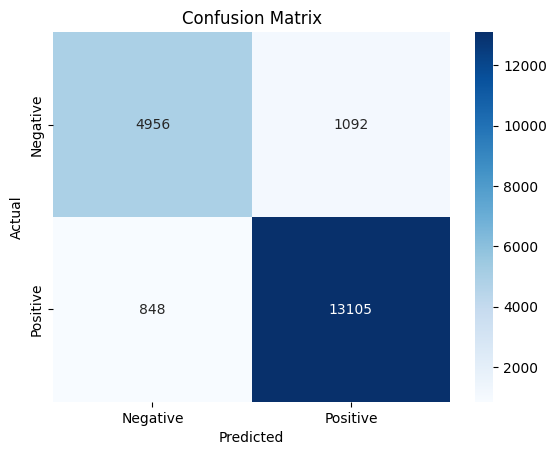

In [8]:
# Evaluate the model on the test set
y_pred_gru = (model_gru.predict(test_padded) > 0.5).astype("int32")

# Confusion Matrix
conf_matrix_gru = confusion_matrix(test_labels, y_pred_gru)
print("Confusion Matrix:")
print(conf_matrix_gru)

# Displaying the confusion matrix using seaborn
sns.heatmap(conf_matrix_gru, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [9]:
# Classification Report
class_report_gru = classification_report(test_labels, y_pred_gru, target_names=['Negative', 'Positive'])
print("Classification Report:")
print(class_report_gru)

Classification Report:
              precision    recall  f1-score   support

    Negative       0.85      0.82      0.84      6048
    Positive       0.92      0.94      0.93     13953

    accuracy                           0.90     20001
   macro avg       0.89      0.88      0.88     20001
weighted avg       0.90      0.90      0.90     20001



In [10]:
# Build CNN model
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length))
model_cnn.add(Conv1D(128, 5, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(1, activation='sigmoid'))

# Compile the model
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_cnn.fit(train_padded, train_labels, epochs=2, validation_data=(test_padded, test_labels), batch_size=16)


Epoch 1/2
5000/5000 [==============================] - 1000s 200ms/step - loss: 0.2857 - accuracy: 0.8783 - val_loss: 0.2450 - val_accuracy: 0.9007
Epoch 2/2
5000/5000 [==============================] - 990s 198ms/step - loss: 0.1766 - accuracy: 0.9321 - val_loss: 0.2604 - val_accuracy: 0.8973


626/626 [==============================] - 8s 13ms/step
Confusion Matrix:
[[ 5132   916]
 [ 1139 12814]]


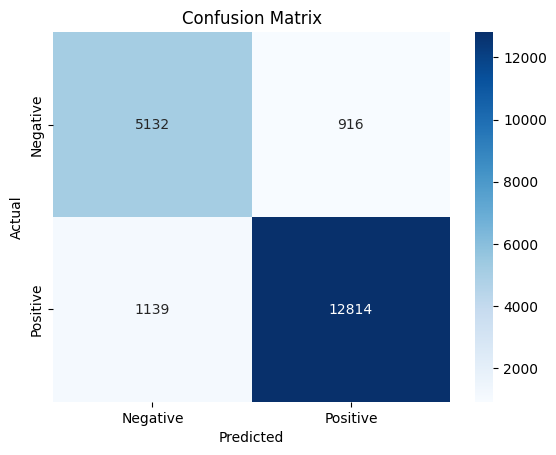

In [11]:
# Evaluate the model on the test set
y_pred_cnn = (model_cnn.predict(test_padded) > 0.5).astype("int32")

# Confusion Matrix
conf_matrix_cnn = confusion_matrix(test_labels, y_pred_cnn)
print("Confusion Matrix:")
print(conf_matrix_cnn)

# Displaying the confusion matrix using seaborn
sns.heatmap(conf_matrix_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [12]:
# Classification Report
class_report_cnn = classification_report(test_labels, y_pred_cnn, target_names=['Negative', 'Positive'])
print("Classification Report:")
print(class_report_cnn)

Classification Report:
              precision    recall  f1-score   support

    Negative       0.82      0.85      0.83      6048
    Positive       0.93      0.92      0.93     13953

    accuracy                           0.90     20001
   macro avg       0.88      0.88      0.88     20001
weighted avg       0.90      0.90      0.90     20001

